# Analyze industrial sensor data

## Import required packages

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Define constants used throughout the notebook

In [2]:
DATAPATH='~/Downloads/'

## Read input files

In [3]:
readings_df=pd.read_csv(DATAPATH+'readings.csv.gz',compression='gzip')
sensors_df=pd.read_csv(DATAPATH+'sensor.csv')
devices_df=pd.read_csv(DATAPATH+'device.csv')

In [4]:
print('Number of readings: {}'.format(len(readings_df)))
print('Number of sensors: {}'.format(len(sensors_df)))
print('Number of devices: {}'.format(len(devices_df)))

Number of readings: 945938
Number of sensors: 27
Number of devices: 4


Show the top 5 rows of every dataframe

In [5]:
readings_df.head()

,device_id,tsepoch,sensor_id,value
0,0,1483228800000,1,0.000000
1,0,1483228800000,2,0.000000
2,0,1483228800000,3,0.000000
3,0,1483228800000,4,1.046513
4,0,1483228800000,5,0.000000


In [6]:
sensors_df.head()

,sensor_id,description,low_value,high_value
0,1,Oil Pressure,0,1
1,2,Air Pressure,0,1
2,3,Oil Temperature Celsius,0,1
3,4,Ambient Temperature Celsius,0,1
4,5,Partial Oxygen Pressure,0,1


In [7]:
devices_df.head()

,device_id,device_type,device_name
0,0,ROV,Calibration
1,1,ROV,RX3194-1
2,2,ROV,RX6710-3
3,3,ROV,RX6199-9


## Convert epoch timestamp to datetime

In [8]:
readings_df['ts']=pd.to_datetime(readings_df['tsepoch'],unit='ms')
readings_df.head()

,device_id,tsepoch,sensor_id,value,ts
0,0,1483228800000,1,0.000000,2017-01-01
1,0,1483228800000,2,0.000000,2017-01-01
2,0,1483228800000,3,0.000000,2017-01-01
3,0,1483228800000,4,1.046513,2017-01-01
4,0,1483228800000,5,0.000000,2017-01-01


### Determine time span of the readings

In [9]:
start_tsepoch=readings_df['tsepoch'].min()
end_tsepoch=readings_df['tsepoch'].max()
start_time=readings_df['ts'].min()
end_time=readings_df['ts'].max()
print('Sample data set spans readings from {} to {}'.format(start_time,end_time))
print('Number of seconds spanned by date set: {}'.format((end_tsepoch-start_tsepoch)/1000))

Sample data set spans readings from 2017-01-01 00:00:00 to 2017-01-01 00:14:24
Number of seconds spanned by date set: 864.0


### Determine number of readings for each sensor

In [10]:
sensor_counts=readings_df.groupby('sensor_id').size()

In [11]:
%matplotlib inline

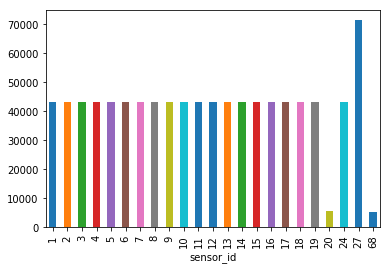

In [12]:
sensor_counts.plot(kind='bar')

### Determine statistics for each sensor and write to new CSV file

In [13]:
sensor_statsdf=readings_df.groupby('sensor_id')['value'].agg(['count','min','max','mean']).reset_index()
sensor_statsdf.head()

,sensor_id,count,min,max,mean
0,1,43200,0.000000,0.000000,0.000000
1,2,43200,0.000000,0.000000,0.000000
2,3,43200,0.000000,0.000000,0.000000
3,4,43200,0.648343,1.354323,0.999279
4,5,43200,0.000000,0.000000,0.000000


In [14]:
sensors_with_stats_df=sensors_df.merge(sensor_statsdf).drop(['low_value','high_value','count'], axis=1)
sensors_with_stats_df.columns=['sensor_id','description','low_value','high_value','mean_value']
sensors_with_stats_df.to_csv(DATAPATH+'sensors_with_stats.csv',index=False)

## Visualization

### Determine which sensors make sense to visualize
Sensors with a minimum and maximum value of 0 are (too) constant and we can ignore them.

In [15]:
non_zero_sensors_df=sensors_with_stats_df.loc[(sensors_with_stats_df['low_value']!=0) | \
                                           (sensors_with_stats_df['high_value']!=0)]
var_readings_df=readings_df.copy()[readings_df.sensor_id.isin(non_zero_sensors_df.sensor_id)]
var_readings_df.head()

,device_id,tsepoch,sensor_id,value,ts
3,0,1483228800000,4,1.046513e+00,2017-01-01
11,0,1483228800000,12,3.222675e+00,2017-01-01
13,0,1483228800000,14,2.434520e+02,2017-01-01
14,0,1483228800000,15,1.527654e+09,2017-01-01
15,0,1483228800000,16,1.872223e+02,2017-01-01


In [16]:
var_readings_df.size

2110690

## Plot some of the sensors

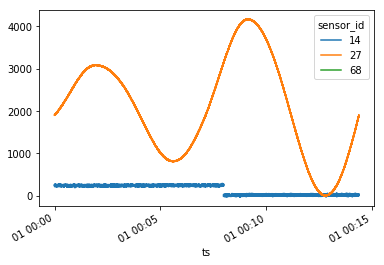

In [17]:
plot_readings_df=var_readings_df.copy()[var_readings_df.sensor_id.isin([14,27,68])]
plot_readings_df=plot_readings_df.pivot_table(index='ts',columns='sensor_id',values='value').reset_index()
plot_readings_df.plot(x='ts')

## Down-sample the different readings
Before we can start looking at correlations between different sensors, we need to match the timestamps of the readings from the different sensos. Let's try and down-sample the variable readings to create a pivoted dataframe with a value for every sensor and every timestamp.

To lose as little detail as possible, we will down-sample to 0.2 seconds. This means there will be 864 * 5 readings for every sensor.

In [18]:
readings_resample_df=var_readings_df.copy().set_index('ts').groupby('sensor_id')['value'].resample('200 ms').mean().reset_index()
readings_resample_df.head()

,sensor_id,ts,value
0,4,2017-01-01 00:00:00.000,1.022362
1,4,2017-01-01 00:00:00.200,0.983486
2,4,2017-01-01 00:00:00.400,0.942015
3,4,2017-01-01 00:00:00.600,0.990852
4,4,2017-01-01 00:00:00.800,1.016707


In [19]:
readings_resample_df.groupby('sensor_id').size()

sensor_id
4     4320
12    4320
14    4320
15    4320
16    4320
17    4320
18    4320
24    4320
27    4320
68    4321
dtype: int64

This is what we expected. We can now pivot the table to find correlations.

## Find correlations between sensors

In [20]:
pivot_readings_df=readings_resample_df.pivot_table(index='ts',columns='sensor_id',values='value').reset_index()
pivot_readings_df.head()

sensor_id,ts,4,12,14,15,16,17,18,24,27,68
0,2017-01-01 00:00:00.000,1.022362,3.106622,236.673392,1.452137e+09,177.932999,0.988788,71.667504,-0.758444,1900.839515,105.162011
1,2017-01-01 00:00:00.200,0.983486,2.916733,237.061628,1.478621e+09,188.979559,0.960407,67.267967,-0.771843,1903.098460,116.368830
2,2017-01-01 00:00:00.400,0.942015,2.941385,238.252973,1.509638e+09,197.380716,0.996847,69.368942,-0.748893,1904.788180,126.253062
3,2017-01-01 00:00:00.600,0.990852,2.920966,228.425294,1.486746e+09,207.556741,0.979921,71.897157,-0.787001,1906.934125,112.097543
4,2017-01-01 00:00:00.800,1.016707,2.914285,234.805413,1.488361e+09,216.353044,1.064194,66.799365,-0.762562,1909.115977,123.677191


Before correlating, let's give the columns some meaningful names.

In [21]:
sensor_cols=pd.DataFrame(pivot_readings_df.columns[1:])
sensor_cols=sensor_cols.astype('int64')

In [22]:
pivot_readings_df.columns=['timestamp'] + sensor_cols.merge(sensors_with_stats_df)['description'].tolist()
pivot_readings_df.head()

,timestamp,Ambient Temperature Celsius,Ambient Pressure mPa,Compressor Actual,Water Pump Pressure Pa,Turbine 1 RPM,Turbine 2 RPM,Torque Correction 1,Wheel 2 Speed RPM,Wheel Front Speed RPM,Wheel Front Temp Celsius
0,2017-01-01 00:00:00.000,1.022362,3.106622,236.673392,1.452137e+09,177.932999,0.988788,71.667504,-0.758444,1900.839515,105.162011
1,2017-01-01 00:00:00.200,0.983486,2.916733,237.061628,1.478621e+09,188.979559,0.960407,67.267967,-0.771843,1903.098460,116.368830
2,2017-01-01 00:00:00.400,0.942015,2.941385,238.252973,1.509638e+09,197.380716,0.996847,69.368942,-0.748893,1904.788180,126.253062
3,2017-01-01 00:00:00.600,0.990852,2.920966,228.425294,1.486746e+09,207.556741,0.979921,71.897157,-0.787001,1906.934125,112.097543
4,2017-01-01 00:00:00.800,1.016707,2.914285,234.805413,1.488361e+09,216.353044,1.064194,66.799365,-0.762562,1909.115977,123.677191


In [23]:
readings_cov=pivot_readings_df.corr()

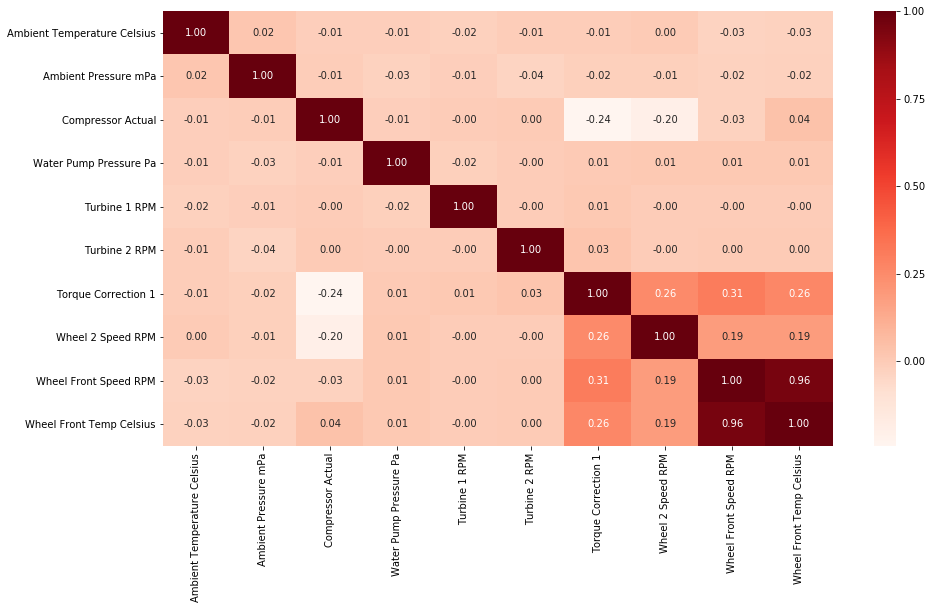

In [24]:
plt.figure(figsize=(15,8))
sns.heatmap(readings_cov, annot=True, fmt='.2f',cmap='Reds')
plt.show()

From the above it is obvious that `Wheel Front Speed RPM` and `Wheel Front Temp Celsius` are strongly correlated, let's plot this in a regression plot.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


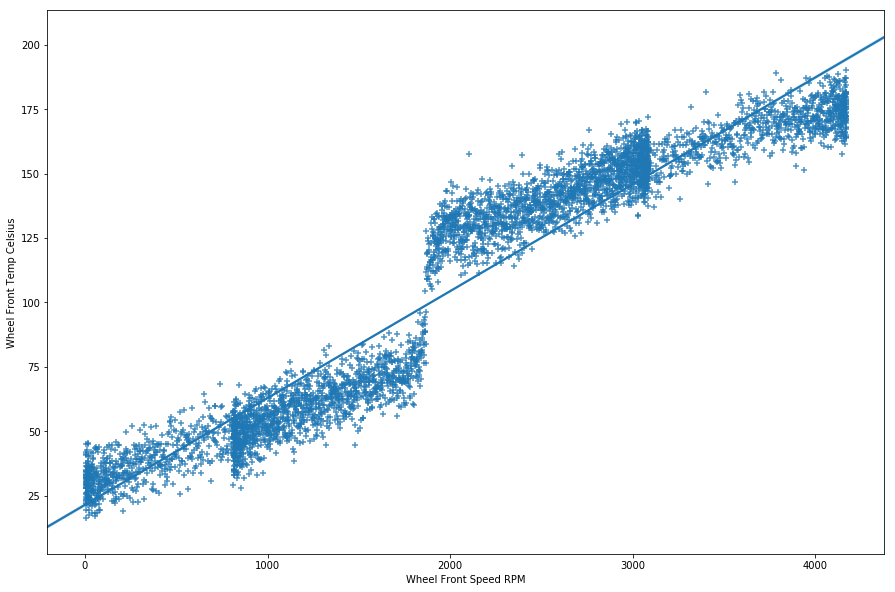

In [25]:
plt.figure(figsize=(15,10))
sns.regplot(pivot_readings_df['Wheel Front Speed RPM'], pivot_readings_df['Wheel Front Temp Celsius'],marker='+')
plt.show()

The covariance between the speed and temperature is clearly visible in the chart above.

## Train model on the data

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Split the data in a training and test set
First remove any NaN values from the overall test set, otherwise the training or testing of the model will fail.

In [27]:
speed_temp_df=pivot_readings_df[['timestamp','Wheel Front Speed RPM','Wheel Front Temp Celsius']].dropna()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(speed_temp_df['Wheel Front Speed RPM'], speed_temp_df['Wheel Front Temp Celsius'],\
                                                   test_size=0.2)

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (3456, 1)
X_test shape:  (864, 1)
y_train shape:  (3456, 1)
y_test shape:  (864, 1)


### First try simple linear model

In [29]:
lm=LinearRegression()
simple_lm=lm.fit(X_train, y_train)
print('Simple linear model R-square score: {}'.format(simple_lm.score(X_test,y_test)))

Simple linear model R-square score: 0.9184454121926394


### Try to improve the score with a polynomial regression
To use a polynomial regression, it is best to create a pipeline that will first generate the polynomial features and then train.

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

In [31]:
# Define the pipeline
poly_pipe=Pipeline([("polynomial_features",PolynomialFeatures(degree=3)),("linear_regression",LinearRegression())])
pm=poly_pipe.fit(X_train, y_train)
print('Polynomial model R-square score: {}'.format(pm.score(X_test,y_test)))

Polynomial model R-square score: 0.9562137048795841


### Now plot everything in 1 diagram

In [32]:
speed_temp_plot_df=speed_temp_df.copy()
speed_temp_plot_df['predicted_linreg']=simple_lm.predict(speed_temp_plot_df['Wheel Front Speed RPM'].values.reshape(-1,1))
speed_temp_plot_df['predicted_poly']=pm.predict(speed_temp_plot_df['Wheel Front Speed RPM'].values.reshape(-1,1))
speed_temp_plot_df.head()

,timestamp,Wheel Front Speed RPM,Wheel Front Temp Celsius,predicted_linreg,predicted_poly
0,2017-01-01 00:00:00.000,1900.839515,105.162011,100.298284,101.282141
1,2017-01-01 00:00:00.200,1903.098460,116.368830,100.391961,101.409674
2,2017-01-01 00:00:00.400,1904.788180,126.253062,100.462034,101.505073
3,2017-01-01 00:00:00.600,1906.934125,112.097543,100.551025,101.626231
4,2017-01-01 00:00:00.800,1909.115977,123.677191,100.641506,101.749419


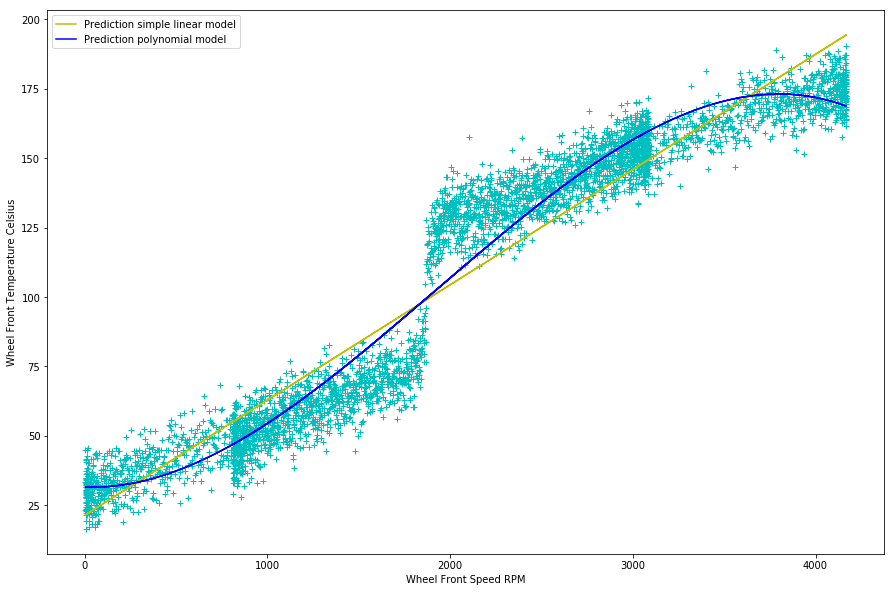

In [33]:
plt.figure(figsize=(15,10))
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['Wheel Front Temp Celsius'].values,'c+')
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['predicted_linreg'].values,'y', label='Prediction simple linear model')
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['predicted_poly'].values,'b', label='Prediction polynomial model')
plt.legend(loc='upper left')
plt.xlabel('Wheel Front Speed RPM')
plt.ylabel('Wheel Front Temperature Celsius')
plt.show()

## TODO: Receive and score live data